# 15b - Miniature Figure Strategy

Create tiny, schematic RDMs that illustrate how temporal shifting (0/1/2) changes the trial‑matching scheme used in inter‑subject RSA. This notebook does not perform real analysis; it only fabricates toy distances so the figure can visually explain the method in the paper.

In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Load minimal deps and point to the figure directory.

In [2]:
figures_folder = Path("../figures")
output_folder = figures_folder / "15_shifted_vs_unshifted_rsa"
output_folder.mkdir(exist_ok=True, parents=True)

2. Helper: build trial pairings for a given shift
generate_matching takes a list of (image, repetition) pairs and returns how they are matched after applying a cyclic repetition shift.

- shift=0: (1→1, 2→2, 3→3) — unshifted

- shift=1: (1→2, 2→3, 3→1)

- shift=2: (1→3, 2→1, 3→2)


In [3]:
def generate_matching(data, shift=0):
    """Generates an rdm based on the repetitions and images provided in data.
    Matches images identities, but shifts the repetitions according to the shift parameter.
    If shift=0, no shift is applied. (rep 1->1, 2->2, 3->3)
    If shift=1, rep 1->2, 2->3, 3->1
    If shift=2, rep 1->3, 2->1, 3->2
    """
    df_1 = pd.DataFrame(data)
    df_2 = df_1.copy()
    # Replace image 3 with image 5
    df_2["image"] = df_2["image"].replace(3, 5)
    df_2 = df_2.rename(columns={"image": "image", "repetition": "repetition_2"})
    # Merge with image=image and repetition = (repetition_2 -1 + shift) % 3 + 1
    if shift == 0:
        c = 0
    elif shift == 1:
        c = 2
    elif shift == 2:
        c = 1

    df_2["repetition"] = (df_2["repetition_2"] + c - 1) % 3 + 1
    df_merge = df_1.merge(df_2, on=["image", "repetition"])
    df_merge

    df_merge["name_1"] = "(" + df_merge.image.astype(str) + ", " + df_merge.repetition.astype(str) + ")"
    df_merge["name_2"] = "(" + df_merge.image.astype(str) + ", " + df_merge.repetition_2.astype(str) + ")"

    df_merge = df_merge.query("image < 4")
    df_merge
    return df_merge


3. Mock distance function

Define a toy “similarity” (0 = identical trial, 1 = maximally different) just to give structure to the heatmaps:

- Same image & same repetition → 0
- Different image, same repetition → 0.33
- Same image, different repetition → 0.66
- Different image & repetition → 1.0

In [4]:
def compute_similarity(image_1: int, image_2: int, rep_1: int, rep_2: int):
    """Mock up similarity function"""
    # If image_1 = image_2 and rep_1 == rep_2 -> return 0
    if image_1 == image_2 and rep_1 == rep_2:
        return 0.0
    if image_1 != image_2 and rep_1 == rep_2:
        return 0.33
    if image_1 == image_2 and rep_1 != rep_2:
       return 0.66
    return 1

Test if strategy is working as expected by generating a mock matching pairs for each shift and plotting them.

In [5]:
data = [
    {'image': 1, 'repetition': 1},
    {'image': 2, 'repetition': 1},
    {'image': 1, 'repetition': 2},
    {'image': 3, 'repetition': 1},

    {'image': 2, 'repetition': 2},
    {'image': 1, 'repetition': 3},
    {'image': 3, 'repetition': 2},
    {'image': 4, 'repetition': 1},

    {'image': 2, 'repetition': 3},
    {'image': 4, 'repetition': 2},
    {'image': 3, 'repetition': 3},
    {'image': 4, 'repetition': 3},

]

for shift in [0, 1, 2]:
    print("Matching trials for shift =", shift)
    display(generate_matching(data, shift=shift))

Matching trials for shift = 0


,image,repetition,repetition_2,name_1,name_2
0,1,1,1,"(1, 1)","(1, 1)"
1,2,1,1,"(2, 1)","(2, 1)"
2,1,2,2,"(1, 2)","(1, 2)"
3,2,2,2,"(2, 2)","(2, 2)"
4,1,3,3,"(1, 3)","(1, 3)"
6,2,3,3,"(2, 3)","(2, 3)"


Matching trials for shift = 1


,image,repetition,repetition_2,name_1,name_2
0,1,1,2,"(1, 1)","(1, 2)"
1,2,1,2,"(2, 1)","(2, 2)"
2,1,2,3,"(1, 2)","(1, 3)"
3,2,2,3,"(2, 2)","(2, 3)"
4,1,3,1,"(1, 3)","(1, 1)"
6,2,3,1,"(2, 3)","(2, 1)"


Matching trials for shift = 2


,image,repetition,repetition_2,name_1,name_2
0,1,1,3,"(1, 1)","(1, 3)"
1,2,1,3,"(2, 1)","(2, 3)"
2,1,2,1,"(1, 2)","(1, 1)"
3,2,2,1,"(2, 2)","(2, 1)"
4,1,3,2,"(1, 3)","(1, 2)"
6,2,3,2,"(2, 3)","(2, 2)"


5. Base RDM (unshifted order)
Compute a full pairwise matrix once, then just re‑index rows/cols to illustrate each shift.

In [6]:

df1_rdm = []
for d in data:
    for d2 in data:
        df1_rdm.append(
            {'image_1': d.get("image"),
             "image_2": d2.get("image"),
             "rep_1": d.get("repetition"),
             "rep_2": d2.get("repetition")
            }
        )
df1_rdm = pd.DataFrame(df1_rdm)
df1_rdm = df1_rdm.query("image_1 != 3 and image_2 != 3")

df1_rdm["similarity"] =  df1_rdm.apply(lambda row: compute_similarity(row.image_1, row.image_2, row.rep_1, row.rep_2), axis=1)

df1_rdm["tuple_x"] = "(" +  df1_rdm.image_1.astype(str) + ", " + df1_rdm.rep_1.astype(str) + ")"
df1_rdm["tuple_y"] = "(" +  df1_rdm.image_2.astype(str) + ", " + df1_rdm.rep_2.astype(str) + ")"

df1_rdm = df1_rdm.pivot(index="tuple_x", columns="tuple_y", values="similarity")
df1_rdm

tuple_y,"(1, 1)","(1, 2)","(1, 3)","(2, 1)","(2, 2)","(2, 3)","(4, 1)","(4, 2)","(4, 3)"
tuple_x,,,,,,,,,
"(1, 1)",0.00,0.66,0.66,0.33,1.00,1.00,0.33,1.00,1.00
"(1, 2)",0.66,0.00,0.66,1.00,0.33,1.00,1.00,0.33,1.00
"(1, 3)",0.66,0.66,0.00,1.00,1.00,0.33,1.00,1.00,0.33
"(2, 1)",0.33,1.00,1.00,0.00,0.66,0.66,0.33,1.00,1.00
"(2, 2)",1.00,0.33,1.00,0.66,0.00,0.66,1.00,0.33,1.00
"(2, 3)",1.00,1.00,0.33,0.66,0.66,0.00,1.00,1.00,0.33
"(4, 1)",0.33,1.00,1.00,0.33,1.00,1.00,0.00,0.66,0.66
"(4, 2)",1.00,0.33,1.00,1.00,0.33,1.00,0.66,0.00,0.66
"(4, 3)",1.00,1.00,0.33,1.00,1.00,0.33,0.66,0.66,0.00


6. Plot miniature RDMs for shift = 0 / 1 / 2

For each shift, we order rows (original trials) against columns (shifted matches) and draw a small heatmap — no ticks, just the pattern.

Plotting RDM for shift = 0


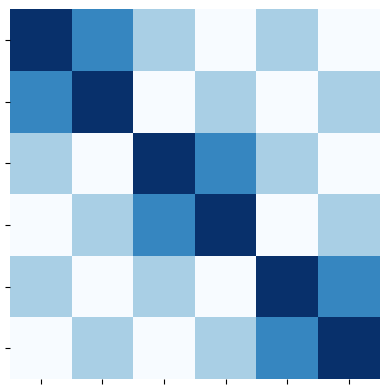

Plotting RDM for shift = 1


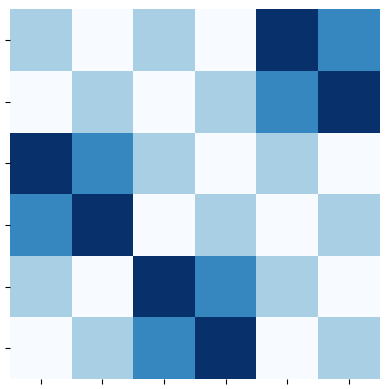

Plotting RDM for shift = 2


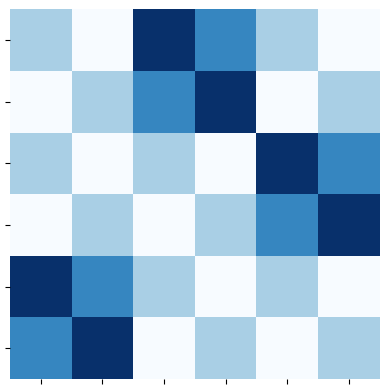

In [7]:
for shift in [0, 1, 2]:
    print("Plotting RDM for shift =", shift)
    df_merge = generate_matching(data, shift=shift)
    original_order = df_merge.name_1.tolist()
    shifted = df_merge.name_2.tolist()
    fig, ax = plt.subplots()
    sns.heatmap(data=df1_rdm.loc[original_order, shifted], cmap="Blues_r", ax=ax, cbar=False, vmin=0, vmax=1)
    ax.set_aspect("equal")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    filename = f"0_miniature_shifted_rdm_shift_{shift}.pdf"
    fig.savefig(output_folder / filename, bbox_inches="tight", transparent=True)
    plt.show()